In [1]:
import pandas as pd
import os
from pathlib import Path
import re

def load_trading_data() -> dict[str, pd.DataFrame]:
    """
    Load trading data from CSV files in round directories into pandas DataFrames,
    keeping only the latest round's data for each day.

    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing the following DataFrames:
            - 'prices': Price data for all days (latest round only)
            - 'trades': Trade data for all days (latest round only)
            - 'observations': Observation data for all days (latest round only)
    """
    # Dictionary to track the latest round for each day and data type
    latest_data = {
        'prices': {},
        'trades': {},
        'observations': {}
    }
    
    # Regex to find round directories (format: round-X-island-data-bottle)
    round_pattern = re.compile(r'^round-(\d+)-island-data-bottle$')
    
    # Regex to match files and extract type and day
    file_pattern = re.compile(r'^(prices|trades|observations)_round_(\d+)_day_(\d+)\.csv$')
    
    # Get the current directory
    current_dir = Path('.')
    print(current_dir.absolute())
    
    # First find all round directories
    round_dirs = []
    for item in current_dir.iterdir():
        if item.is_dir():
            match = round_pattern.match(item.name)
            if match:
                round_num = int(match.group(1))
                round_dirs.append((round_num, item))
    
    # Sort by round number to process in order
    round_dirs.sort()
    
    # Process each round directory
    for round_num, round_dir in round_dirs:
        for file in round_dir.iterdir():
            if file.is_file():
                match = file_pattern.match(file.name)
                if match:
                    data_type, _, day = match.groups()
                    day = int(day)
                    
                    # If we haven't seen this day yet, or if this round is newer
                    if day not in latest_data[data_type] or round_num > latest_data[data_type][day]['round']:
                        sep = ';' if data_type in ['prices', 'trades'] else ','
                        df = pd.read_csv(file, sep=sep)
                        df['day'] = day
                        df['round'] = round_num
                        if 'timestamp' in df.columns:
                            df = df.sort_values('timestamp')
                        
                        latest_data[data_type][day] = {
                            'round': round_num,
                            'data': df
                        }

    # Combine data for each type
    result = {}
    for key, day_data in latest_data.items():
        if day_data:  # Only add if we found any data
            dfs = [info['data'] for info in day_data.values()]
            result[key] = pd.concat(dfs, ignore_index=True)
            if 'timestamp' in result[key].columns:
                result[key].sort_values(['day', 'timestamp'], inplace=True)

    return result

def convert_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(t=(df['day']) * 1_000_000 + df['timestamp']).drop(columns=['day', 'timestamp'])

In [2]:
trading_data = load_trading_data()
prices = convert_timestamp(trading_data['prices']).drop(columns='round')

/Users/cartertran/Development/imc-prosperity-3


In [3]:
prices

,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,t
0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100.0,19.0,NaN,NaN,NaN,NaN,99.5,0.0,0
1,VOLCANIC_ROCK,10502.0,205.0,NaN,NaN,NaN,NaN,10504.0,146.0,10505.0,59.0,NaN,NaN,10503.0,0.0,0
2,SQUID_INK,1968.0,30.0,NaN,NaN,NaN,NaN,1971.0,30.0,NaN,NaN,NaN,NaN,1969.5,0.0,0
3,VOLCANIC_ROCK_VOUCHER_10250,273.0,19.0,NaN,NaN,NaN,NaN,274.0,19.0,NaN,NaN,NaN,NaN,273.5,0.0,0
4,VOLCANIC_ROCK_VOUCHER_9500,1003.0,19.0,NaN,NaN,NaN,NaN,1004.0,19.0,NaN,NaN,NaN,NaN,1003.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739995,PICNIC_BASKET1,58434.0,1.0,58433.0,10.0,58432.0,30.0,58443.0,1.0,58444.0,10.0,58445.0,30.0,58438.5,0.0,4999900
739996,VOLCANIC_ROCK_VOUCHER_9750,356.0,11.0,NaN,NaN,NaN,NaN,357.0,11.0,NaN,NaN,NaN,NaN,356.5,0.0,4999900
739997,RAINFOREST_RESIN,9992.0,35.0,NaN,NaN,NaN,NaN,9999.0,1.0,10008.0,35.0,NaN,NaN,9995.5,0.0,4999900
739998,VOLCANIC_ROCK_VOUCHER_10000,122.0,11.0,NaN,NaN,NaN,NaN,123.0,11.0,NaN,NaN,NaN,NaN,122.5,0.0,4999900


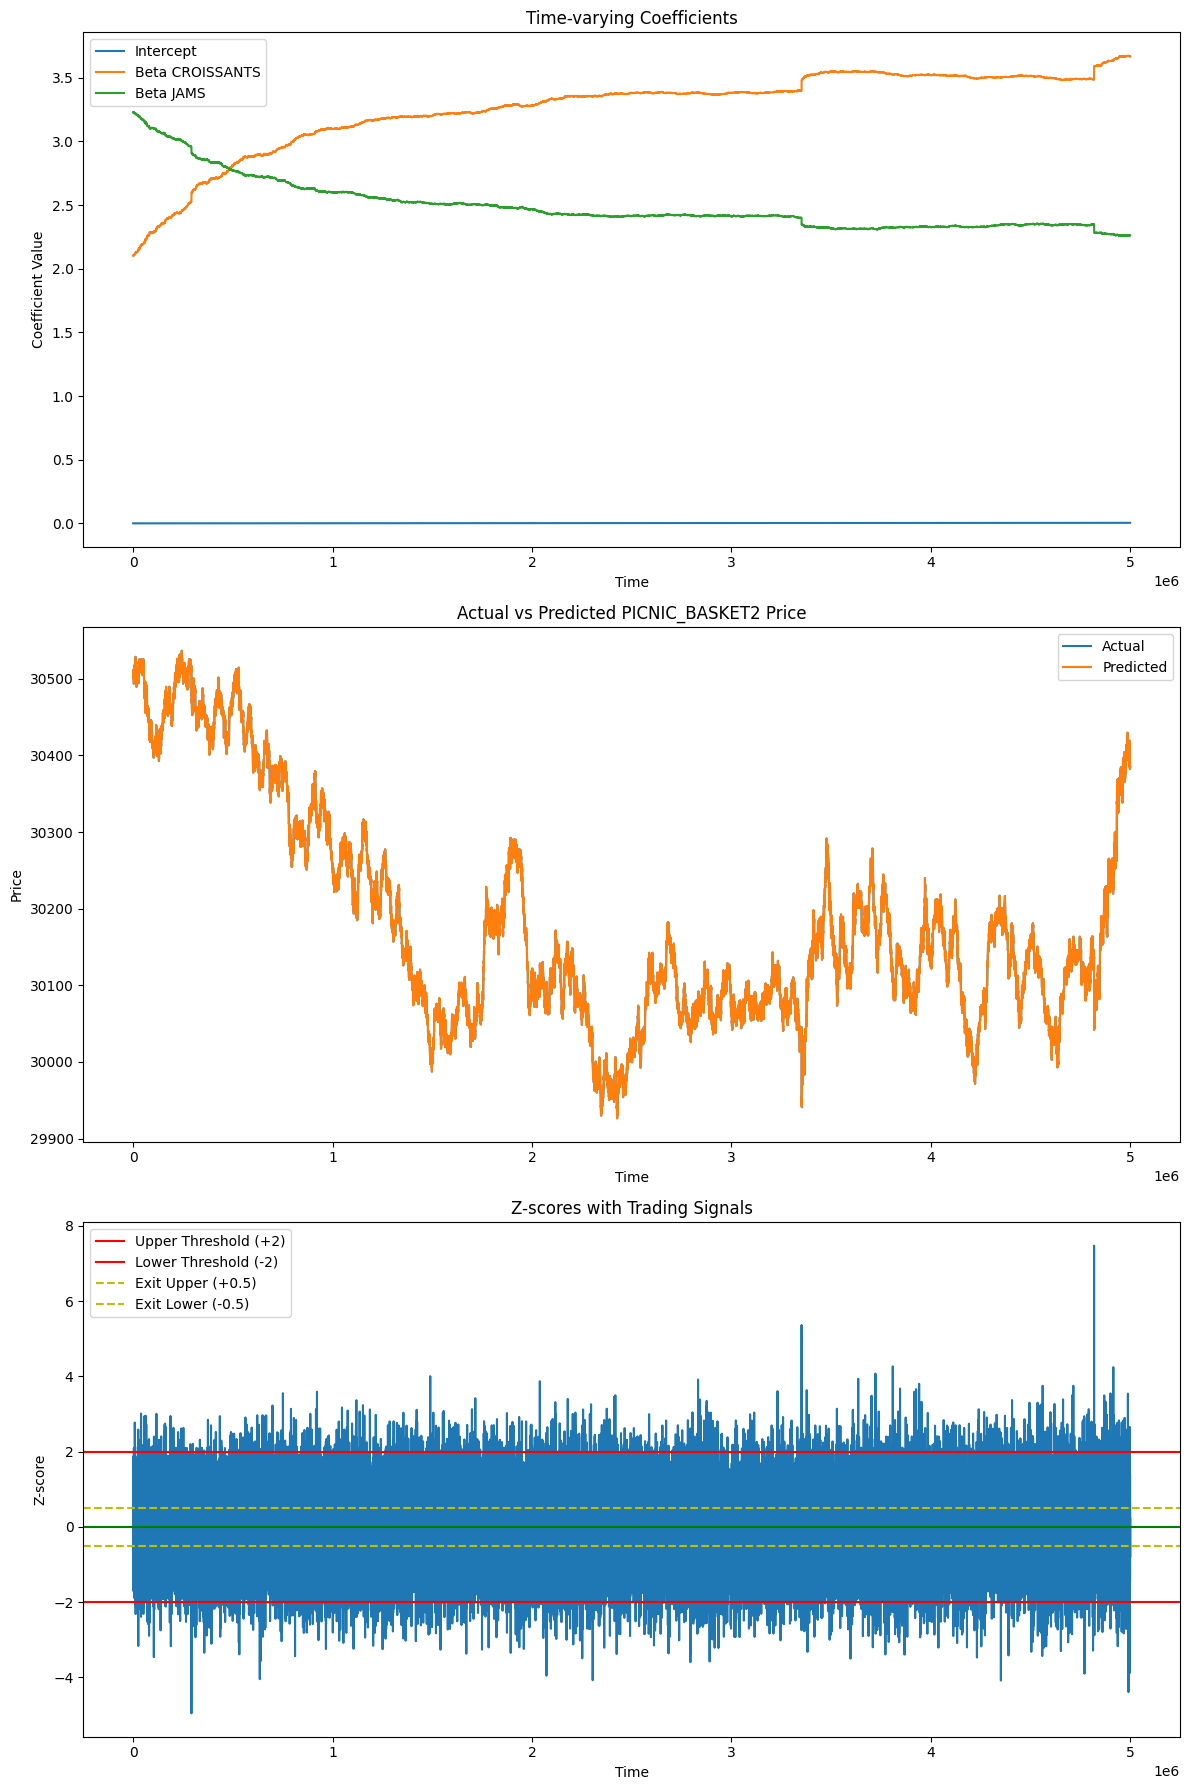

ADF Statistic: -172.94992885580473
p-value: 0.0
Critical Values:
	1%: -3.430480797947222
	5%: -2.8615978100063884
	10%: -2.566800770354459
Number of long entry signals: 1129
Number of short entry signals: 1124
Number of long exit signals: 11419
Number of short exit signals: 11483


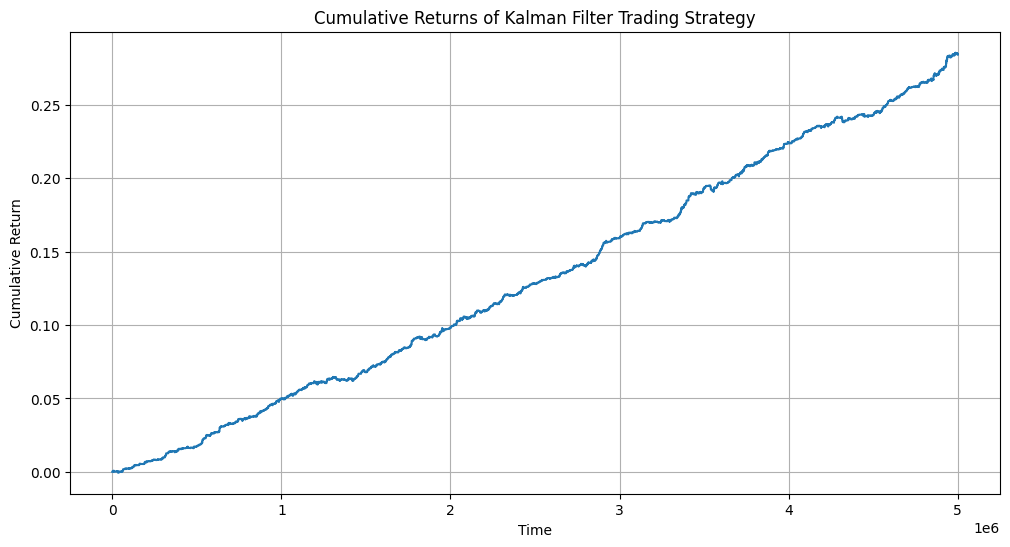


Strategy Performance Summary:
Total Return: 0.2844
Sharpe Ratio: 1.0613
Win Rate: 0.6392


In [7]:
# Import additional required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import adfuller

def prepare_basket_data(df, basket_name="PICNIC_BASKET2", components=["CROISSANTS", "JAMS"]):
    """
    Extract and align time series data for a basket and its components.
    
    Args:
        df: DataFrame containing price data
        basket_name: Name of the basket product
        components: List of component products
    
    Returns:
        DataFrame with aligned time series for basket and components
    """
    # List of products to extract
    products = [basket_name] + components
    
    # Filter the DataFrame to include only the required products
    basket_data = {}
    for product in products:
        # Filter rows for this product and select only timestamp and mid_price
        product_data = df[df['product'] == product][['t', 'mid_price']]
        # Rename mid_price to product name
        product_data = product_data.rename(columns={'mid_price': product})
        # Drop any duplicate timestamps
        product_data = product_data.drop_duplicates('t')
        # Set timestamp as index
        product_data = product_data.set_index('t')
        basket_data[product] = product_data
    
    # Merge all product data on timestamp
    aligned_data = pd.concat([basket_data[product] for product in products], axis=1)
    
    # Drop rows with missing values
    aligned_data = aligned_data.dropna()
    
    # Reset index to have t as a column
    aligned_data = aligned_data.reset_index()
    
    return aligned_data

# Implement Kalman filter for basket trading
def kalman_filter_basket(data, basket_name="PICNIC_BASKET2", components=["CROISSANTS", "JAMS"]):
    # Extract y (basket price) and X (component prices)
    y = data[basket_name].values
    X = np.column_stack([np.ones(len(data)), data[components].values])
    
    # Initial state
    n_states = len(components) + 1  # intercept + component coefficients
    initial_state_mean = np.zeros(n_states)
    initial_state_cov = np.eye(n_states) * 1000  # High initial uncertainty
    
    # In pykalman, observation_matrices should be (n_timesteps, n_dim_obs, n_dim_state)
    # For a scalar observation, n_dim_obs=1
    # We need to reshape X to handle this
    observation_matrices = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Create and initialize Kalman filter
    kf = KalmanFilter(
        transition_matrices=np.eye(n_states),  # Random walk for coefficients
        observation_matrices=observation_matrices,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_cov,
        transition_covariance=np.eye(n_states) * 0.01,  # Controls adaptation speed
        observation_covariance=np.array([[1.0]]),  # Must be a 1x1 matrix for scalar observations
        em_vars=['transition_covariance', 'observation_covariance']
    )
    
    # Filter data to get state estimates
    filtered_state_means, filtered_state_covariances = kf.filter(y)
    
    # Calculate predicted values using matrix multiplication for each time step
    predicted_values = np.sum(X * filtered_state_means, axis=1)
    
    # Calculate residuals
    residuals = y - predicted_values
    
    # Calculate z-scores for residuals
    z_scores = (residuals - np.mean(residuals)) / np.std(residuals)
    
    return {
        'filtered_state_means': filtered_state_means,
        'filtered_state_covariances': filtered_state_covariances,
        'predicted_values': predicted_values,
        'residuals': residuals,
        'z_scores': z_scores,
        'observation_matrices': X
    }

# Function to evaluate the model and visualize results
def evaluate_kalman_model(data, results, basket_name="PICNIC_BASKET2", components=["CROISSANTS", "JAMS"]):
    # Extract results
    filtered_state_means = results['filtered_state_means']
    predicted_values = results['predicted_values']
    residuals = results['residuals']
    z_scores = results['z_scores']
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot 1: Time-varying coefficients
    axs[0].plot(data['t'], filtered_state_means[:, 0], label='Intercept')
    for i, component in enumerate(components):
        axs[0].plot(data['t'], filtered_state_means[:, i+1], label=f'Beta {component}')
    axs[0].set_title('Time-varying Coefficients')
    axs[0].legend()
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Coefficient Value')
    
    # Plot 2: Actual vs Predicted Basket Price
    axs[1].plot(data['t'], data[basket_name], label='Actual')
    axs[1].plot(data['t'], predicted_values, label='Predicted')
    axs[1].set_title(f'Actual vs Predicted {basket_name} Price')
    axs[1].legend()
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Price')
    
    # Plot 3: Z-scores with Trading Signals
    axs[2].plot(data['t'], z_scores)
    axs[2].axhline(y=2, color='r', linestyle='-', label='Upper Threshold (+2)')
    axs[2].axhline(y=-2, color='r', linestyle='-', label='Lower Threshold (-2)')
    axs[2].axhline(y=0, color='g', linestyle='-')
    axs[2].axhline(y=0.5, color='y', linestyle='--', label='Exit Upper (+0.5)')
    axs[2].axhline(y=-0.5, color='y', linestyle='--', label='Exit Lower (-0.5)')
    axs[2].set_title('Z-scores with Trading Signals')
    axs[2].legend()
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Z-score')
    
    plt.tight_layout()
    plt.show()
    
    # Perform Augmented Dickey-Fuller test on residuals
    adf_result = adfuller(residuals)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")
    
    # Convert z_scores to pandas Series for shifting
    z_scores_series = pd.Series(z_scores)
    
    # Trading signal analysis
    long_signals = (z_scores < -2)
    short_signals = (z_scores > 2)
    exit_long_signals = (z_scores_series > -0.5) & (z_scores_series.shift(1) < -0.5)
    exit_short_signals = (z_scores_series < 0.5) & (z_scores_series.shift(1) > 0.5)
    
    print(f"Number of long entry signals: {np.sum(long_signals)}")
    print(f"Number of short entry signals: {np.sum(short_signals)}")
    print(f"Number of long exit signals: {np.sum(exit_long_signals)}")
    print(f"Number of short exit signals: {np.sum(exit_short_signals)}")

# Function to implement trading strategy
def implement_trading_strategy(data, results, basket_name="PICNIC_BASKET2", components=["CROISSANTS", "JAMS"]):
    filtered_state_means = results['filtered_state_means']
    # Create a DataFrame to store trading signals and P&L
    trading_df = pd.DataFrame({
        't': data['t'],
        basket_name: data[basket_name],
        'predicted': results['predicted_values'],
        'residual': results['residuals'],
        'z_score': results['z_scores']
    })
    
    # Add component prices
    for component in components:
        trading_df[component] = data[component]
    
    # Generate trading signals
    trading_df['long_entry'] = trading_df['z_score'] < -2
    trading_df['short_entry'] = trading_df['z_score'] > 2
    trading_df['long_exit'] = (trading_df['z_score'] > -0.5) & (trading_df['z_score'].shift(1) < -0.5)
    trading_df['short_exit'] = (trading_df['z_score'] < 0.5) & (trading_df['z_score'].shift(1) > 0.5)
    
    # Initialize position tracking
    trading_df['position'] = 0
    current_position = 0
    
    # Calculate positions based on signals
    for i in range(len(trading_df)):
        if trading_df.loc[i, 'long_entry'] and current_position == 0:
            current_position = 1  # Long basket, short components
        elif trading_df.loc[i, 'short_entry'] and current_position == 0:
            current_position = -1  # Short basket, long components
        elif trading_df.loc[i, 'long_exit'] and current_position == 1:
            current_position = 0  # Exit long
        elif trading_df.loc[i, 'short_exit'] and current_position == -1:
            current_position = 0  # Exit short
        
        trading_df.loc[i, 'position'] = current_position
    
    # Calculate returns
    trading_df['basket_return'] = trading_df[basket_name].pct_change()
    
    # Calculate weighted component returns
    component_returns = pd.DataFrame()
    for i, component in enumerate(components):
        component_returns[component] = trading_df[component].pct_change() * filtered_state_means[:, i+1]
    
    trading_df['component_return'] = component_returns.sum(axis=1)
    
    # Calculate strategy return
    trading_df['strategy_return'] = trading_df['position'].shift(1) * (
        trading_df['basket_return'] - trading_df['component_return']
    )
    
    # Calculate cumulative returns
    trading_df['cumulative_return'] = trading_df['strategy_return'].fillna(0).cumsum()
    
    return trading_df

# Main execution code
# Extract PICNIC_BASKET2 and its components (CROISSANTS, JAMS)
basket_name = "PICNIC_BASKET2"
components = ["CROISSANTS", "JAMS"]

# Prepare the data
aligned_data = prepare_basket_data(prices, basket_name, components)

# Apply Kalman filter
kalman_results = kalman_filter_basket(aligned_data, basket_name, components)

# Evaluate the model
evaluate_kalman_model(aligned_data, kalman_results, basket_name, components)

# Implement trading strategy
trading_results = implement_trading_strategy(aligned_data, kalman_results, basket_name, components)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(trading_results['t'], trading_results['cumulative_return'])
plt.title('Cumulative Returns of Kalman Filter Trading Strategy')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Summary statistics
print("\nStrategy Performance Summary:")
print(f"Total Return: {trading_results['cumulative_return'].iloc[-1]:.4f}")
print(f"Sharpe Ratio: {trading_results['strategy_return'].mean() / trading_results['strategy_return'].std() * np.sqrt(252):.4f}")
print(f"Win Rate: {np.sum(trading_results['strategy_return'] > 0) / np.sum(trading_results['strategy_return'] != 0):.4f}")

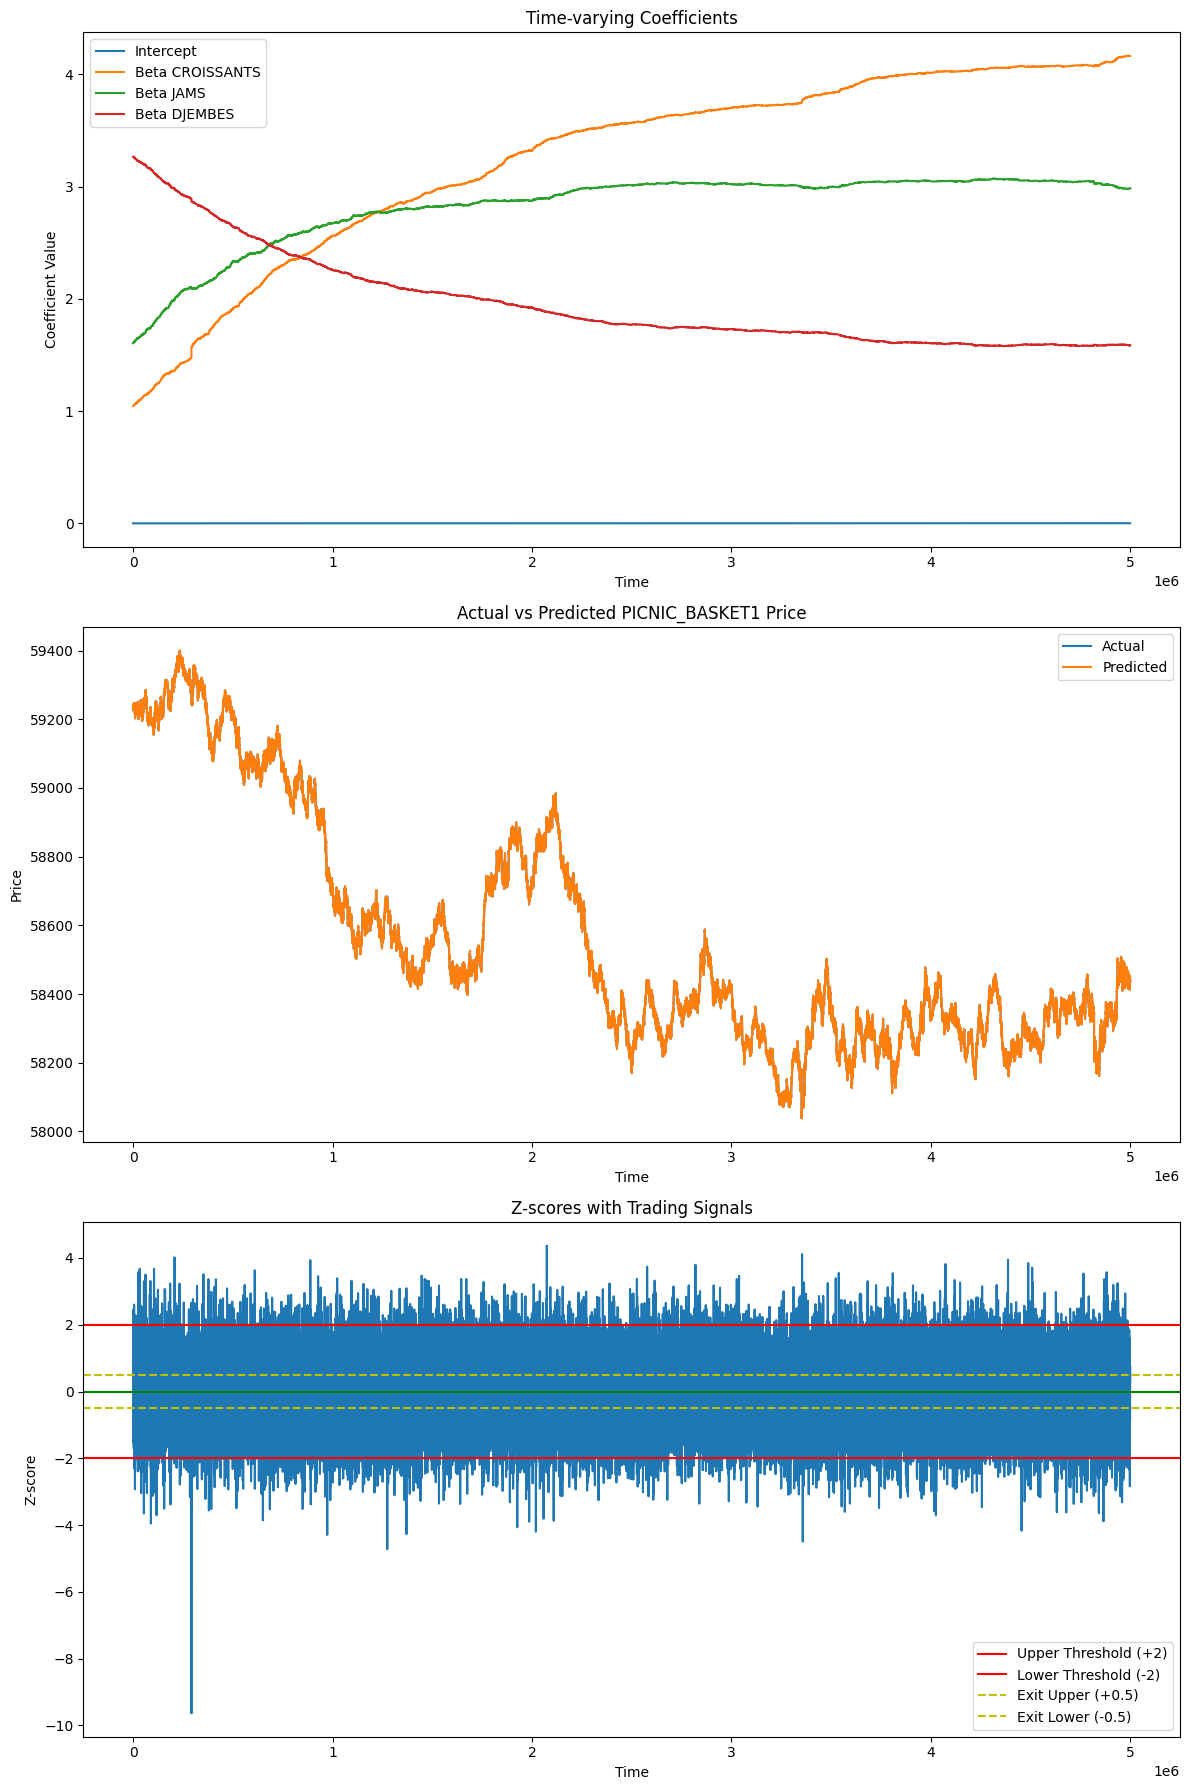

ADF Statistic: -168.40389911781728
p-value: 0.0
Critical Values:
	1%: -3.430480797947222
	5%: -2.8615978100063884
	10%: -2.566800770354459
Number of long entry signals: 1149
Number of short entry signals: 1131
Number of long exit signals: 11209
Number of short exit signals: 11228


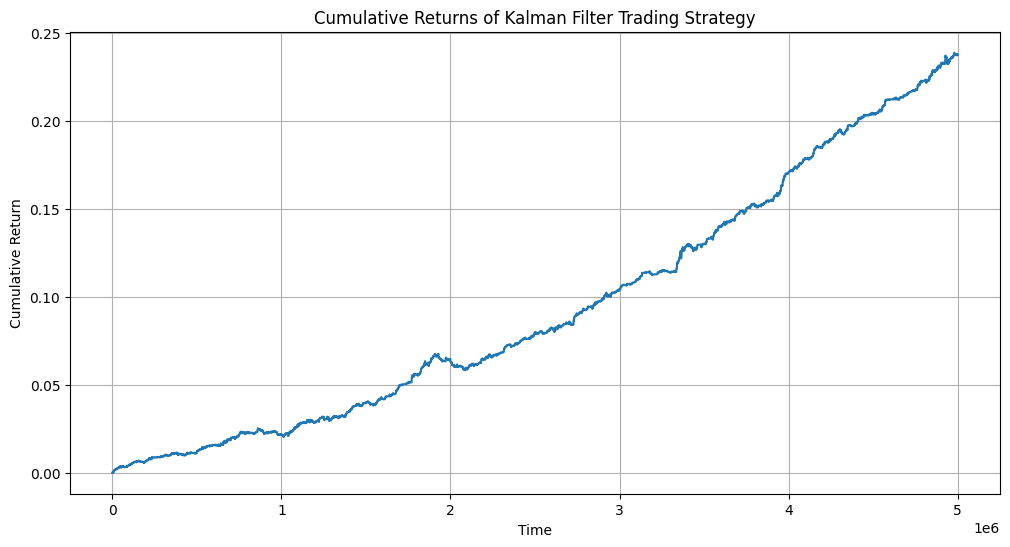


Strategy Performance Summary:
Total Return: 0.2376
Sharpe Ratio: 0.7712
Win Rate: 0.5964


In [8]:
basket_name = "PICNIC_BASKET1"
components = ["CROISSANTS", "JAMS", "DJEMBES"]

# Prepare the data
aligned_data = prepare_basket_data(prices, basket_name, components)

# Apply Kalman filter
kalman_results = kalman_filter_basket(aligned_data, basket_name, components)

# Evaluate the model
evaluate_kalman_model(aligned_data, kalman_results, basket_name, components)

# Implement trading strategy
trading_results = implement_trading_strategy(aligned_data, kalman_results, basket_name, components)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(trading_results['t'], trading_results['cumulative_return'])
plt.title('Cumulative Returns of Kalman Filter Trading Strategy')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# Summary statistics
print("\nStrategy Performance Summary:")
print(f"Total Return: {trading_results['cumulative_return'].iloc[-1]:.4f}")
print(f"Sharpe Ratio: {trading_results['strategy_return'].mean() / trading_results['strategy_return'].std() * np.sqrt(252):.4f}")
print(f"Win Rate: {np.sum(trading_results['strategy_return'] > 0) / np.sum(trading_results['strategy_return'] != 0):.4f}")